In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import asyncio
import os
from dataclasses import dataclass, field
from typing import Literal

import pandas as pd
from dotenv import load_dotenv
from dspy import LM, ChainOfThought, InputField, OutputField, Signature, configure
from fastembed import TextEmbedding
from langchain.schema import Document
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from langchain_tavily import TavilySearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field
from typing_extensions import Any

In [ ]:
_ = load_dotenv()
llm = ChatDeepSeek(model="deepseek-chat")
df = pd.read_csv("data/generative_ai_medical_imaging_2019-2025.csv")
df["Title_Abstract"] = df["Title"] + ".\n " + df["Abstract"].fillna("")
df.drop(columns=["Title", "Abstract"], inplace=True)
df.to_csv("data/tests.csv", index=False)

In [ ]:
embeddings = TextEmbedding(
    model_name="jinaai/jina-embeddings-v2-base-de",
    cache_dir=os.path.expanduser("~/.cache/fastembed"),
)

splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=100,
)

loader = CSVLoader(
    file_path="data/tests.csv",
    source_column="Pmid",
    content_columns=["Title_Abstract"],
    metadata_columns=[
        "Pmid",
        "Url",
        "Authors",
        "Keywords",
        "Journal",
        "Affiliations",
        "Publication Date",
        "References",
    ],
)

documents = loader.load()
splitted_documents = splitter.split_documents(documents)

In [ ]:
splitted_documents[1].page_content

'<b>Background/Objectives</b>: The integration of artificial intelligence (AI) in medical imaging is rapidly advancing, yet its application in gynecologic use remains limited. This proof-of-concept study presents the development and validation of a convolutional neural network (CNN) designed to automatically detect and classify endometrial polyps. <b>Methods</b>: A multicenter dataset (n = 3) comprising 65 hysteroscopies was used, yielding 33,239 frames and 37,512 annotated objects. Still frames were extracted from full-length videos and annotated for the presence of histologically confirmed polyps. A YOLOv1-based object detection model was used with a 70-20-10 split for training, validation, and testing. Primary performance metrics included recall, precision, and mean average precision'

In [ ]:
def batch_process(
    documents: list[Document],
    embeddings,
    persist_directory,
    batch_size=10,
):
    # Check if the persist directory exists
    if not os.path.exists(persist_directory):
        logger.warning(
            f"Persist directory {persist_directory} does not exist. Creating it"
        )
        os.makedirs(persist_directory, exist_ok=True)

    # Create the batches
    batch_docs = [
        documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
    ]

    if os.path.exists(os.path.join(persist_directory, "index.faiss")):
        logger.info(
            f"Vector Index already exists. Loading it from {persist_directory}."
        )
        vector_index = FAISS.load_local(
            persist_directory,
            embeddings=embeddings,
            allow_dangerous_deserialization=True,
        )
    else:
        logger.info("Creating new FAISS index from documents")
        # Create the vector_store
        vector_index = FAISS.from_documents(batch_docs[0], embeddings)

        for batch in batch_docs[1:]:
            vector_index.add_documents(batch)

        # Persist the index
        vector_index.save_local(persist_directory)

    return vector_index

In [ ]:
@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, documents: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(documents)]

    def embed_query(self, query: str) -> list[float]:
        return list(self.fe.embed([query]))[0].tolist()


embedding_model = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-de",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
    )
)

In [ ]:
vector_store = batch_process(
    splitted_documents, embedding_model, persist_directory="faiss_index"
)

2025-09-03 21:40:41.574 | INFO     | __main__:batch_process:20 - Vector Index already exists. Loading it from faiss_index.


In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

# result = retriever.invoke("How has artificial intelligence helped propagate medicine?")

In [ ]:
class StructuredOutput(BaseModel):
    answer: list[str] = Field(description="A List of search queries")


dspy_lm = LM(
    "deepseek/deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
)
configure(lm=dspy_lm)


class MultiQueryGenerator(Signature):
    """Generate multiple research queries from a single user query."""

    question = InputField(desc="Original user query")
    num_queries = InputField(desc="Number of research queries to generate")
    research_queries: StructuredOutput = OutputField(
        desc="Generate a list of search terms to for the questions to aid in web search for an AI agent"
    )


query_optimizer = ChainOfThought(MultiQueryGenerator)


@traceable(name="query_generator")
def query_generator(question: str, num_queries: int):
    try:
        return query_optimizer(
            question=question, num_queries=num_queries
        ).research_queries.answer
    except Exception as e:
        print(f"An error occurred during query generation: {e}")
        return []

In [ ]:
queries = query_generator(
    "What role can generative AI play in designing novel CAR constructs targeting solid tumors?",
    5,
)

In [ ]:
queries

['generative AI design CAR constructs solid tumors',
 'deep learning optimize CAR-T cell therapy for solid cancers',
 'AI-generated novel CAR antigens targeting tumor microenvironment',
 'reinforcement learning in CAR construct engineering for solid malignancies',
 'generative adversarial networks (GANs) for predicting CAR-T efficacy in solid tumors']

In [ ]:
async def tavily_search_async(
    search_queries: list[str],
    max_results: int = 5,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    tavily_search = TavilySearch(
        max_results=max_results, include_raw_content=include_raw_content, topic=topic
    )
    tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
    results = await asyncio.gather(*tasks)
    return results

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "medical_paper_retriever",
    "Retrieves relevant medical research papers and their metadata (e.g., title, abstract, references) to support evidence-based answers.",
)
# tavily_tool = TavilySearch(max_results=2, topic="general")
search_response = await tavily_search_async(
    queries, max_results=5, include_raw_content=True
)

In [ ]:
@dataclass
class SourceFormatter:
    max_tokens_per_source: int = 1000
    include_raw_content: bool = True
    chars_per_token: int = 5
    markdown_output: bool = False

    @staticmethod
    def _extract_sources_list(
        search_response: dict[str, Any] | list,
    ) -> list[dict[str, Any]]:
        """Extract sources list from various response formats."""
        if isinstance(search_response, dict):
            return search_response.get("results", [])
        elif isinstance(search_response, list):
            sources_list = []
            for response in search_response:
                if isinstance(response, dict) and "results" in response:
                    sources_list.extend(response["results"])
                elif isinstance(response, dict):
                    sources_list.append(response)
                elif isinstance(response, list):
                    sources_list.extend(response)
            return sources_list
        else:
            raise ValueError(
                "Input must be either a dict with 'results' key or a list of search results"
            )

    @staticmethod
    def _truncate_content(content: str, char_limit: int = 4000) -> str:
        """Truncate content to specified character limit."""
        if not content:
            return "No content available"
        if len(content) <= char_limit:
            return content
        truncate_point = content.rfind(" ", 0, char_limit)
        if (
            truncate_point == -1 or truncate_point < char_limit * 0.8
        ):  # Returns -1 if not found, check if the " " occurs before the 80% of the char_limit
            truncate_point = char_limit
        return content[:truncate_point].rstrip() + "... [content truncated]"

    def _format_single_source(
        self,
        source: dict[str, Any],
        index: int,
        char_limit: int,
    ) -> str:
        """Format a single source for display."""
        title = source.get("title", "Untitled Source")
        url = source.get("url", "No URL available")
        content = source.get("content", "No content summary available")
        raw_content = source.get("raw_content", "")

        if self.markdown_output:
            lines = [
                f"## Source {index}: {title}",
                f"**URL:** {url}",
                f"**Summary:** {content}",
            ]
        else:
            lines = [
                f"Source {index}: {title}",
                f"URL: {url}",
                f"Most relevant content: {content}",
            ]

        if self.include_raw_content:
            if raw_content:
                truncated_content = self._truncate_content(raw_content, char_limit)
                token_estimate = char_limit // 4

                if self.markdown_output:
                    lines.append(
                        f"**Full content** (Limited to ~{token_estimate} tokens):"
                    )
                    lines.append(f"```\n{truncated_content}\n```")
                else:
                    lines.append(
                        f"Full source content (limited to ~{token_estimate} tokens):"
                    )
                    lines.append(truncated_content)
            else:
                warning = "No raw content available for this source"
                lines.append(
                    f"**Note:** {warning}"
                    if self.markdown_output
                    else f"Note: {warning}"
                )

        return "\n\n".join(lines)

    def _format_unique_sources(
        self,
        unique_sources: dict[str, dict[str, Any]],
        max_tokens_per_source: int,
        chars_per_token: int,
    ) -> str:
        """Format unique sources for display."""
        char_limit = chars_per_token * max_tokens_per_source
        formatted_sections = []
        for i, (url, source) in enumerate(unique_sources.items(), 1):
            section = self._format_single_source(source, i, char_limit)
            formatted_sections.append(section)

        header = "# Sources\n\n" if self.markdown_output else "Sources:\n\n"
        separator = "\n---\n\n" if self.markdown_output else "\n" + "=" * 50 + "\n\n"
        return header + separator.join(formatted_sections)

    def deduplicate_and_format_sources(
        self,
        search_response: dict[str, Any] | list,
        return_dict: bool = False,
    ) -> str | dict[str, dict[str, Any]]:
        """Extract, deduplicate by URL, and format sources for display."""
        logger.info("Processing sources for deduplication and formatting")

        unique_sources = {}
        sources_list = self._extract_sources_list(search_response)

        for source in sources_list:
            url = source.get("url")
            if url and url not in unique_sources:
                unique_sources[url] = source

        logger.info(f"Found {len(unique_sources)} unique sources")

        if return_dict:
            return unique_sources

        if not unique_sources:
            return "No unique sources found after deduplication"

        return self._format_unique_sources(
            unique_sources,
            self.max_tokens_per_source,
            self.chars_per_token,
        )

In [ ]:
formatter = SourceFormatter(markdown_output=True)
print(formatter.deduplicate_and_format_sources(search_response))

2025-09-03 22:33:59.076 | INFO     | __main__:deduplicate_and_format_sources:113 - Processing sources for deduplication and formatting
2025-09-03 22:33:59.090 | INFO     | __main__:deduplicate_and_format_sources:123 - Found 23 unique sources


# Sources

## Source 1: More Effective Bi-Specific CAR T Cells Developed Using AI

**URL:** https://www.insideprecisionmedicine.com/topics/oncology/more-effective-bi-specific-car-t-cells-developed-using-ai/

**Summary:** A research team at St. Jude Children’s Research Hospital has leveraged AI to use a computational approach to design more effective bi-specific chimeric antigen receptor (CAR) T cells. “We have developed and validated a computational tool that can significantly accelerate the design of tandem CAR constructs with improved surface expression and anti-tumor function,” said senior author Giedre Krenciute, PhD, a member of the department of bone marrow transplantation and cellular therapy (BMTCT) at St. Jude. The researchers said that the need for more computational tools and AI-driven design optimization will become more necessary that as treatments progress toward more complex synthetic proteins, such as bi-specific CARs, TRuCs, and synthetic cytokine receptors.

**Full co

In [ ]:
tools = [retriever_tool]

llm_with_tools = llm.bind_tools(tools)

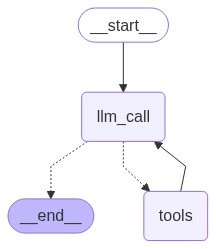

In [ ]:
rag_prompt = """
You are a helpful medical research assistant tasked with retrieving information from PubMed articles. 
Always clarify the user's research question or scope before retrieving. 
Use the retrieval tool to gather relevant PubMed abstracts, metadata, and references. 
Reflect on the retrieved context, prioritize citing references, and synthesize findings into accurate, evidence-based responses. 
If more context is needed, continue retrieving until you have sufficient coverage to answer the user's request thoroughly.
"""


class State(MessagesState):
    texts: str


def llm_call(state: State):
    messages = state.get("messages", [])

    # If no messages yet, start the conversation
    if not messages:
        messages = [
            SystemMessage(content=rag_prompt),
            HumanMessage(content=state["texts"]),
        ]

    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}


# state = State(texts="What are the approaches to Task Decomposition?")
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", "__end__": END}
)
graph.add_edge("tools", "llm_call")

full_graph = graph.compile()
full_graph

In [ ]:
state = State(texts="What are the applications of AI in medicine according to PubMed?")
result = full_graph.invoke(state)

print(result["messages"][-1].content)  # Final assistant answer

Based on my search of PubMed literature, here's a comprehensive overview of the applications of artificial intelligence in medicine:

## Major Applications of AI in Medicine According to PubMed Research

### 1. **Medical Imaging and Diagnostics**
- **Radiology**: AI algorithms significantly improve accuracy and efficiency in interpreting X-rays, CT scans, and MRIs
- **Pathology**: Automated analysis of tissue samples and digital pathology images
- **Cardiology**: Coronary calcium scoring and early detection of cardiovascular abnormalities
- **Breast Cancer Screening**: Enhanced detection in mammography, ultrasound, and MRI
- **Ophthalmology**: Retinal image analysis for early eye disease detection
- **Nuclear Medicine**: AI-assisted image generation and interpretation

### 2. **Clinical Decision Support Systems**
- **Diagnostic Assistance**: AI tools that help physicians interpret complex medical data
- **Treatment Planning**: Personalized treatment recommendations based on patient dat